In [ ]:
# run this chunk in terminal
# virtual env for tensorflow
conda create --name tf-env python=3.10 -y
conda activate tf-env
pip install tensorflow numpy==1.23.5 ipykernel
pip install pandas keras sklearn matplotlib
python -m ipykernel install --user --name=tf-env --display-name "Python (tf-env)"


In [56]:
# select "Python (tf-env)" before running
# import packages
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

Autoencoder: 
substitute proper paths and follow code chunk instructions

In [105]:
# load data
data = pd.read_csv(r"C:\Users\vance\Desktop\project_folder\ec2_cpu_utilization_53ea38.csv")
# data = pd.read_csv(r"C:\Users\vance\Desktop\project_folder\ec2_network_in_5abac7.csv")
# data = pd.read_csv(r"C:\Users\vance\Desktop\project_folder\elb_request_count_8c0756.csv")

In [106]:
# Exclude datetime column
data_values = data.drop('timestamp',axis=1).values

# Convert data to float type
data_values = data_values.astype('float32')

# Create new dataframe with converted values
data_converted = pd.DataFrame(data_values,columns=data.columns[1:])

# Add back datetime column
data_converted.insert(0, 'timestamp',data['timestamp'])

data_converted = data_converted.dropna()


In [ ]:
# choose optimal dim
# use encoding_dim = total_dim*n
# n = [0.8, 0.6, 0.5, 0.4, 0.3]

In [81]:
list_dim = [0.8, 0.6, 0.5, 0.4, 0.3]
results = []
for n in list_dim:
    # Exclude datetime column again
    data_tensor = tf.convert_to_tensor(data_converted.drop(
        'timestamp', axis=1).values, dtype=tf.float32)

    # Define the autoencoder model
    input_dim = data_converted.shape[1] - 1
    total_dim = len(data_converted)
    encoding_dim = int(total_dim * n)

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='relu')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    # Compile and fit the model
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(data_tensor, data_tensor, epochs=50,
                    batch_size=32, shuffle=True, verbose=0)

    # Calculate the reconstruction error for each data point
    reconstructions = autoencoder.predict(data_tensor)
    mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                        axis=1)
    avg_mse = tf.reduce_mean(mse)
    anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
    anomaly_scores.index = data_converted.index
    results.append([n, float(avg_mse)])

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
results_df = pd.DataFrame(results, columns=['n', 'avg_mse'])
results_df
# shows 0.6 smallest mse

,n,avg_mse
0,0.8,3.357562e+00
1,0.6,3.167525e-11
2,0.5,5.612391e-11
3,0.4,4.512771e-11
4,0.3,3.357562e+00


In [107]:
# now run with optimal dimension
# Exclude datetime column again
data_tensor = tf.convert_to_tensor(data_converted.drop(
    'timestamp', axis=1).values, dtype=tf.float32)

n = 0.6
# Define the autoencoder model
input_dim = data_converted.shape[1] - 1
total_dim = len(data_converted)
encoding_dim = int(total_dim * n)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,
                batch_size=32, shuffle=True, verbose=0)

# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                    axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [84]:
# choose optimal threshold
# use num = n
# n = [0.99, 0.95, 0.90, 0.75, 0.5, 0.25]

In [92]:
list_threshold = [0.99, 0.95, 0.90, 0.75, 0.5, 0.25]
results_threshold = []
for num in list_threshold:
    threshold = anomaly_scores.quantile(num)
    anomalous = anomaly_scores > threshold
    binary_labels = anomalous.astype(int)
    precision, recall,\
        f1_score, _ = precision_recall_fscore_support(
            binary_labels, anomalous, average='binary')

    test = data_converted['value'].values
    predictions = anomaly_scores.values

    "Precision: ", precision
    "Recall: ", recall
    "F1 Score: ", f1_score
    results_threshold.append([num, f1_score])

In [94]:
threshold_df = pd.DataFrame(results_threshold, columns=['num', 'f1_score'])
threshold_df

,num,f1_score
0,0.99,1.0
1,0.95,1.0
2,0.90,1.0
3,0.75,1.0
4,0.50,1.0
5,0.25,1.0


In [108]:
# now run with the optimal threshold
num = 0.99
threshold = anomaly_scores.quantile(num)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')

test = data_converted['value'].values
predictions = anomaly_scores.values

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


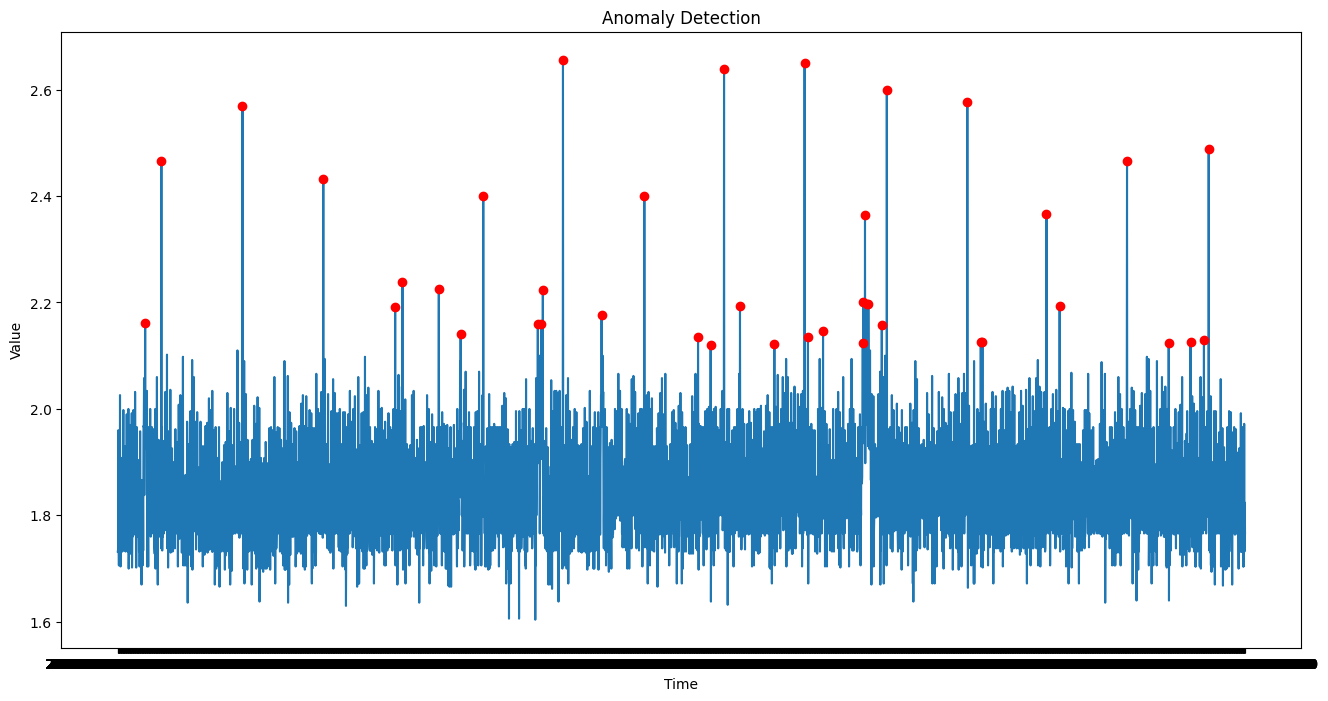

In [109]:
# Plot the data with anomalies marked in red
plt.figure(figsize=(16,8))
plt.plot(data_converted['timestamp'],
         data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous],
         data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig(r"C:\Users\vance\Desktop\project_folder\ec2_cpu_detection.png")
plt.show()

In [110]:
# load data
# data = pd.read_csv(r"C:\Users\vance\Desktop\project_folder\ec2_cpu_utilization_53ea38.csv")
data = pd.read_csv(r"C:\Users\vance\Desktop\project_folder\ec2_network_in_5abac7.csv")
# data = pd.read_csv(r"C:\Users\vance\Desktop\project_folder\elb_request_count_8c0756.csv")
# Exclude datetime column
data_values = data.drop('timestamp',axis=1).values

# Convert data to float type
data_values = data_values.astype('float32')

# Create new dataframe with converted values
data_converted = pd.DataFrame(data_values,columns=data.columns[1:])

# Add back datetime column
data_converted.insert(0, 'timestamp',data['timestamp'])

data_converted = data_converted.dropna()

In [99]:
# choose optimal dim
# use encoding_dim = total_dim*n
# n = [0.8, 0.6, 0.5, 0.4, 0.3]
list_dim = [0.8, 0.6, 0.5, 0.4, 0.3]
results = []
for n in list_dim:
    # Exclude datetime column again
    data_tensor = tf.convert_to_tensor(data_converted.drop(
        'timestamp', axis=1).values, dtype=tf.float32)

    # Define the autoencoder model
    input_dim = data_converted.shape[1] - 1
    total_dim = len(data_converted)
    encoding_dim = int(total_dim * n)

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='relu')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    # Compile and fit the model
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(data_tensor, data_tensor, epochs=50,
                    batch_size=32, shuffle=True, verbose=0)

    # Calculate the reconstruction error for each data point
    reconstructions = autoencoder.predict(data_tensor)
    mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                        axis=1)
    avg_mse = tf.reduce_mean(mse)
    anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
    anomaly_scores.index = data_converted.index
    results.append([n, float(avg_mse)])
results_df = pd.DataFrame(results, columns=['n', 'avg_mse'])
results_df

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,n,avg_mse
0,0.8,6.157055e+11
1,0.6,3.370010e-01
2,0.5,6.157055e+11
3,0.4,5.654483e+00
4,0.3,6.777370e-02


In [111]:
# now run with optimal dimension
# Exclude datetime column again
data_tensor = tf.convert_to_tensor(data_converted.drop(
    'timestamp', axis=1).values, dtype=tf.float32)

n = 0.6
# Define the autoencoder model
input_dim = data_converted.shape[1] - 1
total_dim = len(data_converted)
encoding_dim = int(total_dim * n)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,
                batch_size=32, shuffle=True, verbose=0)

# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                    axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [102]:
# choose optimal threshold
# use num = n
# n = [0.99, 0.95, 0.90, 0.75, 0.5, 0.25]
list_threshold = [0.99, 0.95, 0.90, 0.75, 0.5, 0.25]
results_threshold = []
for num in list_threshold:
    threshold = anomaly_scores.quantile(num)
    anomalous = anomaly_scores > threshold
    binary_labels = anomalous.astype(int)
    precision, recall,\
        f1_score, _ = precision_recall_fscore_support(
            binary_labels, anomalous, average='binary')

    test = data_converted['value'].values
    predictions = anomaly_scores.values

    "Precision: ", precision
    "Recall: ", recall
    "F1 Score: ", f1_score
    results_threshold.append([num, f1_score])
threshold_df = pd.DataFrame(results_threshold, columns=['num', 'f1_score'])
threshold_df

,num,f1_score
0,0.99,1.0
1,0.95,1.0
2,0.90,1.0
3,0.75,1.0
4,0.50,1.0
5,0.25,1.0


In [112]:
# now run with the optimal threshold
num = 0.99
threshold = anomaly_scores.quantile(num)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')

test = data_converted['value'].values
predictions = anomaly_scores.values

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Precision:  1.0
Recall:  1.0
F1 Score:  1.0


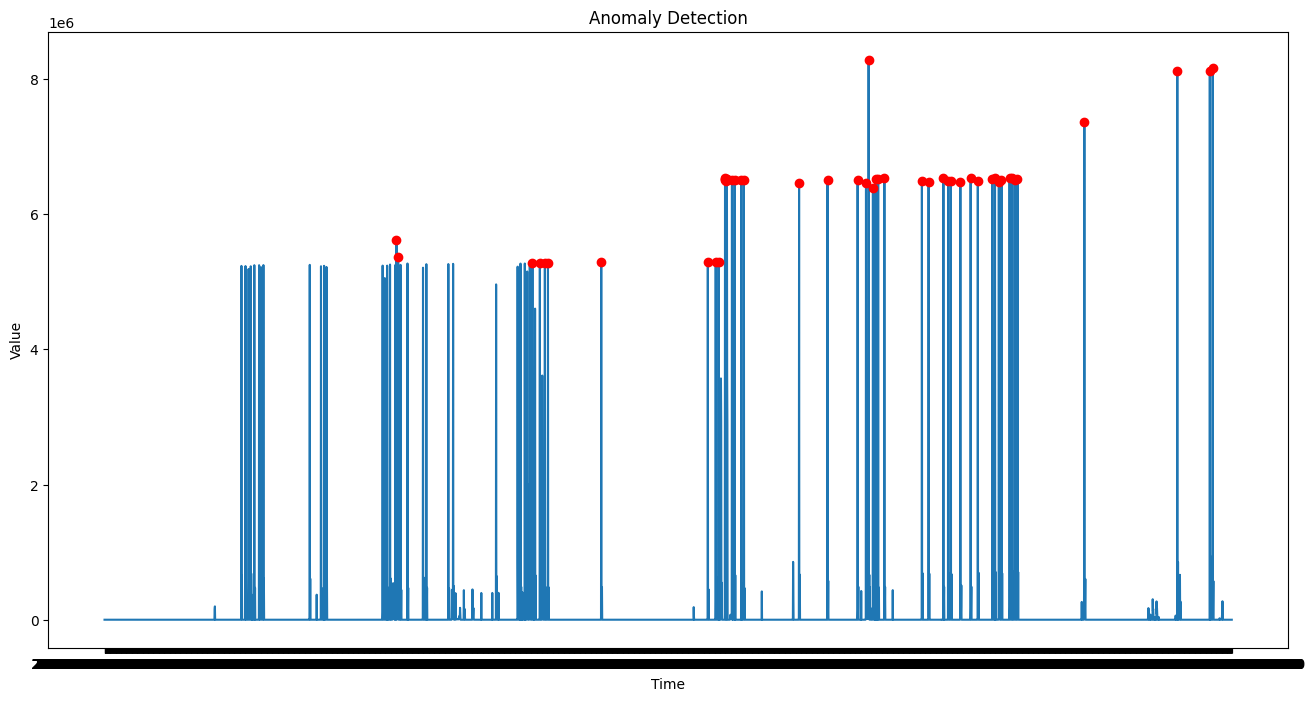

In [113]:
# Plot the data with anomalies marked in red
plt.figure(figsize=(16,8))
plt.plot(data_converted['timestamp'],
         data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous],
         data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig(r"C:\Users\vance\Desktop\project_folder\ec2_network_detection.png")
plt.show()

In [114]:
# load data
# data = pd.read_csv(r"C:\Users\vance\Desktop\project_folder\ec2_cpu_utilization_53ea38.csv")
# data = pd.read_csv(r"C:\Users\vance\Desktop\project_folder\ec2_network_in_5abac7.csv")
data = pd.read_csv(r"C:\Users\vance\Desktop\project_folder\elb_request_count_8c0756.csv")
# Exclude datetime column
data_values = data.drop('timestamp',axis=1).values

# Convert data to float type
data_values = data_values.astype('float32')

# Create new dataframe with converted values
data_converted = pd.DataFrame(data_values,columns=data.columns[1:])

# Add back datetime column
data_converted.insert(0, 'timestamp',data['timestamp'])

data_converted = data_converted.dropna()


In [115]:
# choose optimal dim
# use encoding_dim = total_dim*n
# n = [0.8, 0.6, 0.5, 0.4, 0.3]
list_dim = [0.8, 0.6, 0.5, 0.4, 0.3]
results = []
for n in list_dim:
    # Exclude datetime column again
    data_tensor = tf.convert_to_tensor(data_converted.drop(
        'timestamp', axis=1).values, dtype=tf.float32)

    # Define the autoencoder model
    input_dim = data_converted.shape[1] - 1
    total_dim = len(data_converted)
    encoding_dim = int(total_dim * n)

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='relu')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    # Compile and fit the model
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(data_tensor, data_tensor, epochs=50,
                    batch_size=32, shuffle=True, verbose=0)

    # Calculate the reconstruction error for each data point
    reconstructions = autoencoder.predict(data_tensor)
    mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                        axis=1)
    avg_mse = tf.reduce_mean(mse)
    anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
    anomaly_scores.index = data_converted.index
    results.append([n, float(avg_mse)])
results_df = pd.DataFrame(results, columns=['n', 'avg_mse'])
results_df


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,n,avg_mse
0,0.8,7.033914e+03
1,0.6,8.559126e-04
2,0.5,7.033914e+03
3,0.4,1.055250e-06
4,0.3,1.866563e-07


In [ ]:
# now run with optimal dimension
# Exclude datetime column again
data_tensor = tf.convert_to_tensor(data_converted.drop(
    'timestamp', axis=1).values, dtype=tf.float32)

n = 0.8
# Define the autoencoder model
input_dim = data_converted.shape[1] - 1
total_dim = len(data_converted)
encoding_dim = int(total_dim * n)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,
                batch_size=32, shuffle=True, verbose=0)

# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                    axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index


In [ ]:
# choose optimal threshold
# use num = n
# n = [0.99, 0.95, 0.90, 0.75, 0.5, 0.25]
list_threshold = [0.99, 0.95, 0.90, 0.75, 0.5, 0.25]
results_threshold = []
for num in list_threshold:
    threshold = anomaly_scores.quantile(num)
    anomalous = anomaly_scores > threshold
    binary_labels = anomalous.astype(int)
    precision, recall,\
        f1_score, _ = precision_recall_fscore_support(
            binary_labels, anomalous, average='binary')

    test = data_converted['value'].values
    predictions = anomaly_scores.values

    "Precision: ", precision
    "Recall: ", recall
    "F1 Score: ", f1_score
    results_threshold.append([num, f1_score])
threshold_df = pd.DataFrame(results_threshold, columns=['num', 'f1_score'])
threshold_df

In [ ]:
# now run with the optimal threshold
num = 0.95
threshold = anomaly_scores.quantile(num)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')

test = data_converted['value'].values
predictions = anomaly_scores.values

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

In [ ]:
# Plot the data with anomalies marked in red
plt.figure(figsize=(16,8))
plt.plot(data_converted['timestamp'],
         data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous],
         data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()
plt.savefig(r"C:\Users\vance\Desktop\project_folder\elb_req_detection.png")